In [1]:
from model import SugarscapeCg
from agents import Cop, Criminal

from IPython.display import clear_output
from SALib.sample import saltelli
from SALib.analyze import sobol
from mesa.batchrunner import BatchRunner, BatchRunnerMP

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import datetime

## Helper functions

In [2]:
def run_model(model):
    model.run_model()

    output = model.datacollector.get_model_vars_dataframe()
    print(output)

    return output

In [3]:
def get_data(df, key):
    all_rows = df[0][key].values

    for i in range(1, len(df)):
        wealths = df[i][key].values
        all_rows = np.vstack([all_rows, wealths])

    all_rows = all_rows.T

    return all_rows

In [4]:
def get_means_cis(data):
    means = []
    cis = []

    for i in range(data.shape[0]):
        means.append(np.mean(data[i]))
        cis.append(1.96*np.std(data[i])/np.sqrt(data.shape[0]))

    return means, cis

In [5]:
def get_average_crime_per_distr(outputs, district_names, burn_in):
    avg_crimes_per_distr_dict = {'Centrum': 0, 'Nieuw-West': 0, 'Noord': 0, 'Oost': 0, 'West': 0, 'Zuid': 0, 'Zuidoost': 0} 
    for i in range(len(outputs)):
        for district in district_names:
            avg_crimes_per_distr_dict[district] += np.mean(outputs[i].iloc[burn_in:][district])
    for district in district_names:
        avg_crimes_per_distr_dict[district] /= len(outputs)
    return dict(sorted(avg_crimes_per_distr_dict.items(), key=lambda item:item[1]))

## Plotting functions

In [6]:
def plot_errorbars(means, cis, y_axis_label):
    plt.errorbar(x=range(len(means)), y=means, yerr=cis, ecolor='red')
    plt.xlabel("Number of steps")
    plt.ylabel(y_axis_label)

In [7]:
def plot_district_crimes(district_means, district_cis, district_names, district_colors):
    for district_index in range(len(district_means)):
        plt.errorbar(x=range(len(district_means[district_index])), y=district_means[district_index], yerr=district_cis[district_index], label=district_names[district_index], color=district_colors[district_index], ecolor=district_colors[district_index])
        plt.xlabel("Number of steps")
        plt.ylabel('Number of crimes')
    plt.legend()

In [8]:
# def plot_district_crimes_bar(district_means, district_cis, district_names, district_colors):
#     plt.bar(np.arange(len(district_means)), height=district_means, yerr=district_cis, color=district_colors, capsize=10)
#     plt.xticks(np.arange(len(district_means)), district_names)
#     # plt.xlabel("Number of steps")
#     plt.ylabel('Number of crimes')

In [9]:
def plot_district_means_bar(avg_crimes_per_distr_dict, district_colors):
    plt.bar(avg_crimes_per_distr_dict.keys(), avg_crimes_per_distr_dict.values(), color=district_colors)
    plt.legend()
    plt.show()
    return

In [10]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    indices = s['S' + i]
    errors = s['S' + i + '_conf']
    plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

# Sensitivity Analysis

In [11]:
# We define our variables and bounds
problem = {
    'num_vars': 5,
    'names': ['jail_sentence', 'criminal_risk_radius', 'cop_catch_radius', 'criminal_risk_aversion', 'criminal_disconnectivity'],
    'bounds': [[0, 20], [1, 10], [1, 10], [0, 500], [0, 100]]
}

# Set the outputs
model_reporters = {
    "Total crimes": lambda m: m.schedule.get_crimes_commited(), 
    "Criminals in jail": lambda m: m.schedule.get_criminal_count_in_jail(),
    # "Centrum": lambda m: m.get_crimes_per_district()['Centrum'],
    # "Noord": lambda m: m.get_crimes_per_district()['Noord'],
    # "West": lambda m: m.get_crimes_per_district()['West'],
    # "Zuid": lambda m: m.get_crimes_per_district()['Zuid'],
    # "Zuidoost": lambda m: m.get_crimes_per_district()['Zuidoost'],
    # "Oost": lambda m: m.get_crimes_per_district()['Oost'],
    # "Nieuw-West": lambda m: m.get_crimes_per_district()['Nieuw-West'],
    "Centrum": lambda m:m.schedule.update_average_crimes_per_timestep("Centrum").get("Centrum"),
    "Noord": lambda m:m.schedule.update_average_crimes_per_timestep("Noord").get("Noord"),
    "West": lambda m:m.schedule.update_average_crimes_per_timestep("West").get("West"),
    "Zuid": lambda m:m.schedule.update_average_crimes_per_timestep("Zuid").get("Zuid"),
    "Zuidoost": lambda m:m.schedule.update_average_crimes_per_timestep("Zuidoost").get("Zuidoost"),
    "Oost": lambda m:m.schedule.update_average_crimes_per_timestep("Oost").get("Oost"),
    "Nieuw-West": lambda m:m.schedule.update_average_crimes_per_timestep("Nieuw-West").get("Nieuw-West")
}
# model_reporters = {"Data Collector": lambda m: m.datacollector},

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 1#10
max_steps = 300#200
distinct_samples = 500#500

param_values = saltelli.sample(problem, N=distinct_samples, calc_second_order=False)

batch = BatchRunner(SugarscapeCg, 
                    max_steps=max_steps,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (5) is equal to `2^n`.
        
  warnings.warn(msg)


In [12]:
count = 0
data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                columns=['jail_sentence', 'criminal_risk_radius', 'cop_catch_radius', 'criminal_risk_aversion', 'criminal_disconnectivity'])
data['Run'], data['Centrum'], data['Criminals in jail'] = None, None, None
data['Nieuw-West'], data['Noord'], data['Oost'], data['Total crimes'], data['West'], data['Zuid'], data['Zuidoost'] = None, None, None, None, None, None, None

# print(data)

for i in range(replicates):
    for vals in param_values: 
        # Change parameters that should be integers
        vals = list(vals)
        vals = [int(item) for item in vals]
        # print(vals)
        
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val
        # print(variable_parameters)

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = int(count) # Don't know what causes this, but iteration number is not correctly filled
        # print(iteration_data)

        data.iloc[count, :len(problem['names'])] = vals  # fills in varied parameter (this has to span more columns when more than 1 parameter is varied)
        data.iloc[count, len(problem['names']):] = iteration_data  # fills in output data (in this case just 'Run' and 'Crimes')
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')

100.00% done


In [13]:
print(data)

ct = datetime.datetime.now()
filename = 'sensitivity_analysis_output_' + str(ct)
data.to_csv(filename)

   jail_sentence criminal_risk_radius cop_catch_radius criminal_risk_aversion  \
0              1                    5                5                    328   
1             19                    5                5                    328   
2              1                    5                5                    328   
3              1                    5                8                    328   
4              1                    5                5                    234   
..           ...                  ...              ...                    ...   
65             9                    9                8                    140   
66             9                    1                2                    140   
67             9                    1                8                    296   
68             9                    1                8                    140   
69            16                    9                2                    296   

   criminal_disconnectivity

In [14]:
Si_crimes = sobol.analyze(problem, data['Total crimes'].values, calc_second_order=False, print_to_console=True)
Si_jail = sobol.analyze(problem, data['Criminals in jail'].values, calc_second_order=False, print_to_console=True)
Si_centrum = sobol.analyze(problem, data['Centrum'].values, calc_second_order=False, print_to_console=True)
Si_noord = sobol.analyze(problem, data['Noord'].values, calc_second_order=False, print_to_console=True)
Si_west = sobol.analyze(problem, data['West'].values, calc_second_order=False, print_to_console=True)
Si_zuid = sobol.analyze(problem, data['Zuid'].values, calc_second_order=False, print_to_console=True)
Si_zuidoost = sobol.analyze(problem, data['Zuidoost'].values, calc_second_order=False, print_to_console=True)
Si_oost = sobol.analyze(problem, data['Oost'].values, calc_second_order=False, print_to_console=True)
Si_nieuw_west = sobol.analyze(problem, data['Nieuw-West'].values, calc_second_order=False, print_to_console=True)

                                ST   ST_conf
jail_sentence             1.112067  2.383296
criminal_risk_radius      1.049251  1.058917
cop_catch_radius          0.994229  0.712956
criminal_risk_aversion    1.075538  1.374521
criminal_disconnectivity  0.989981  1.002017
                                S1   S1_conf
jail_sentence             0.012670  2.108476
criminal_risk_radius      0.083564  1.274525
cop_catch_radius          0.070004  1.120210
criminal_risk_aversion    0.050841  1.976555
criminal_disconnectivity  0.035273  0.531340
                                ST   ST_conf
jail_sentence             1.123232  0.615486
criminal_risk_radius      1.082828  0.765971
cop_catch_radius          1.195960  0.523555
criminal_risk_aversion    1.147475  0.475627
criminal_disconnectivity  1.082828  0.625791
                                S1   S1_conf
jail_sentence            -0.249351  0.717119
criminal_risk_radius     -0.175469  0.494098
cop_catch_radius         -0.065108  1.054689
criminal_r

{'S1': array([0.01266983, 0.0835643 , 0.07000393, 0.05084058, 0.03527339]), 'S1_conf': array([2.10847588, 1.27452527, 1.12021021, 1.97655463, 0.53133994]), 'ST': array([1.11206704, 1.04925142, 0.99422911, 1.07553805, 0.98998126]), 'ST_conf': array([2.38329553, 1.05891725, 0.71295648, 1.37452078, 1.00201733])}


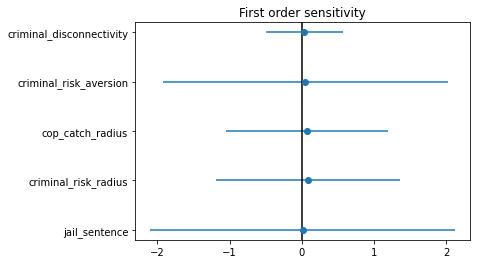

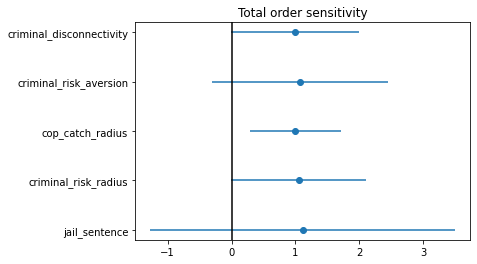

{'S1': array([-0.24935065, -0.17546898, -0.06510823, -0.20225108, -0.23734488]), 'S1_conf': array([0.71711895, 0.4940983 , 1.05468913, 0.62342247, 0.48419431]), 'ST': array([1.12323232, 1.08282828, 1.1959596 , 1.14747475, 1.08282828]), 'ST_conf': array([0.61548645, 0.76597065, 0.52355512, 0.47562736, 0.62579129])}


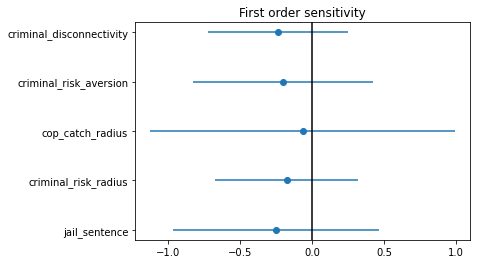

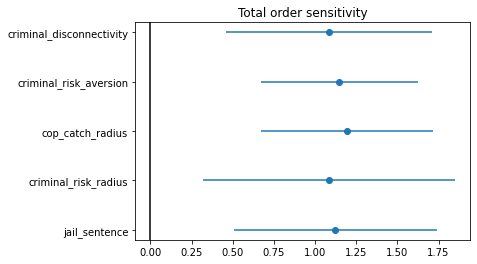

{'S1': array([ 0.33303782,  0.05565615, -0.64336913, -0.21193087, -0.32757758]), 'S1_conf': array([0.51255654, 0.81525376, 0.97149337, 0.97290065, 0.85430228]), 'ST': array([0.66948791, 0.7357314 , 0.61688596, 0.97336384, 1.00627828]), 'ST_conf': array([1.08912291, 0.93944051, 0.6167267 , 1.13681218, 1.35535791])}


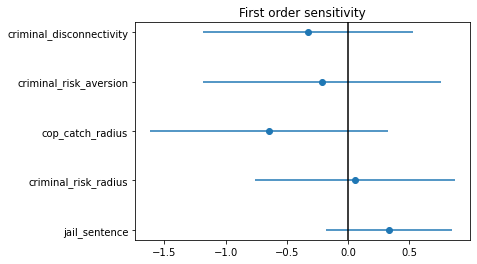

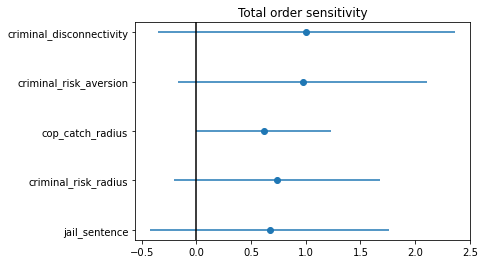

{'S1': array([-0.07534372,  0.02282783,  0.48484675, -0.05706185,  0.26118848]), 'S1_conf': array([0.70290506, 0.64574108, 1.52139794, 0.69756567, 0.84948623]), 'ST': array([1.23320418, 0.83916716, 1.15978903, 0.91532272, 0.98060133]), 'ST_conf': array([1.1550787 , 0.9831876 , 0.73192083, 0.94365655, 0.85672784])}


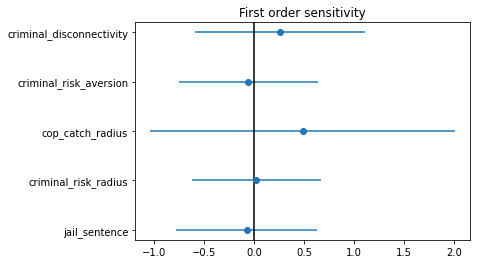

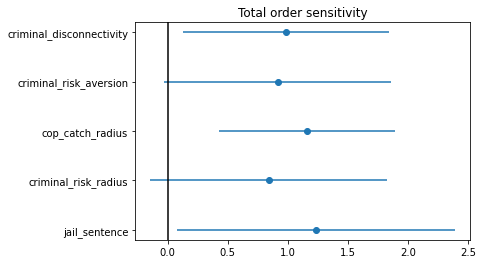

{'S1': array([0.01734075, 0.36843546, 0.39231242, 0.24142456, 0.12462679]), 'S1_conf': array([2.04803532, 1.13979074, 0.72440043, 1.57975039, 0.64116636]), 'ST': array([1.33282711, 0.99767903, 0.76477575, 1.1643353 , 0.7227218 ]), 'ST_conf': array([3.02732669, 0.91151861, 0.67212295, 1.1434346 , 0.88938037])}


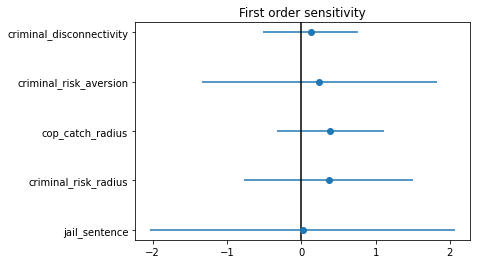

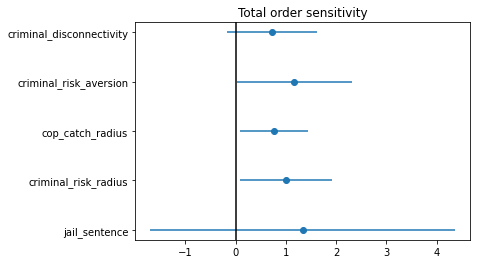

{'S1': array([0.30816233, 0.1114315 , 0.07871683, 0.07675698, 0.24465287]), 'S1_conf': array([0.37924674, 0.84377314, 0.85286611, 0.85711297, 0.90503227]), 'ST': array([0.48554583, 0.52702614, 0.61780761, 0.70375136, 0.91149861]), 'ST_conf': array([0.45052886, 0.39861202, 0.64597503, 0.57166079, 0.72091101])}


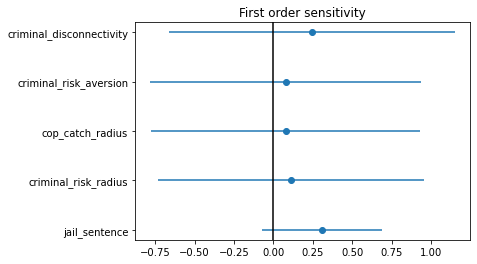

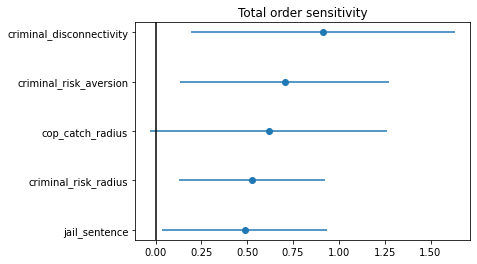

{'S1': array([0.25430026, 0.20679322, 0.3286812 , 0.28517663, 0.19637672]), 'S1_conf': array([0.51196732, 0.60233367, 0.60683154, 0.64621877, 0.73217408]), 'ST': array([0.72381007, 0.6397101 , 0.7487693 , 0.78458335, 0.75776601]), 'ST_conf': array([0.50202425, 0.41399434, 0.33920559, 0.44206855, 0.42552897])}


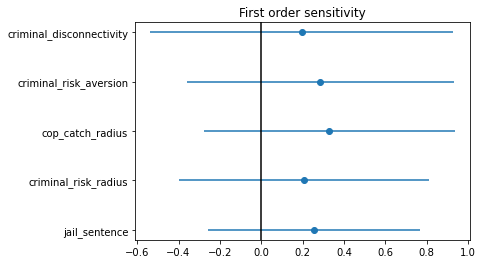

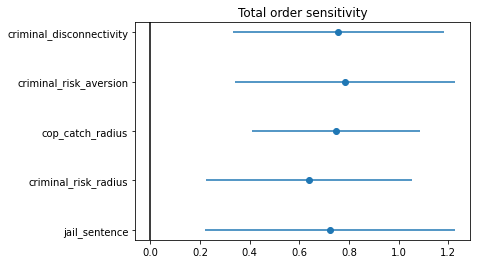

{'S1': array([-0.03323464,  0.0380283 ,  0.48206901,  0.02795045,  0.13983549]), 'S1_conf': array([0.55928361, 0.26149695, 1.51369176, 0.24996096, 0.36057948]), 'ST': array([1.27262014, 0.95237716, 1.38407202, 0.96674539, 0.99006755]), 'ST_conf': array([2.32081619, 0.70698648, 1.46165072, 0.70261228, 0.68010425])}


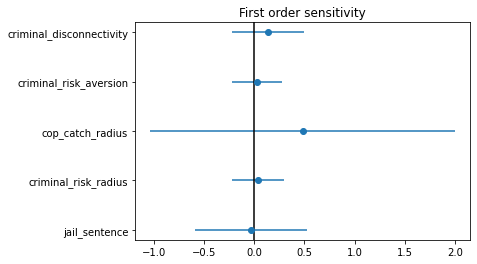

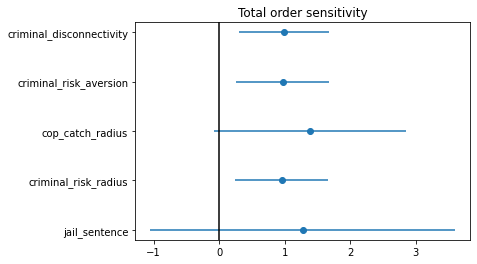

{'S1': array([-0.11428506, -0.04870877,  0.09479948, -0.08331389, -0.08491521]), 'S1_conf': array([0.87311578, 0.33286744, 1.33899199, 0.3994715 , 0.33603151]), 'ST': array([1.07220991, 1.00961989, 1.14963772, 1.02056059, 0.97471809]), 'ST_conf': array([1.38970466, 0.62162887, 2.77702976, 0.52671499, 0.60163048])}


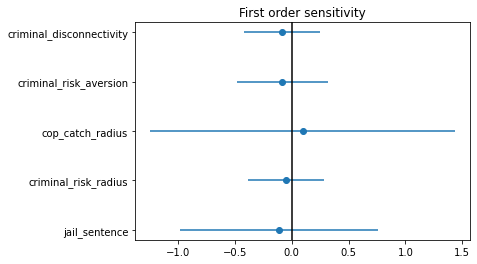

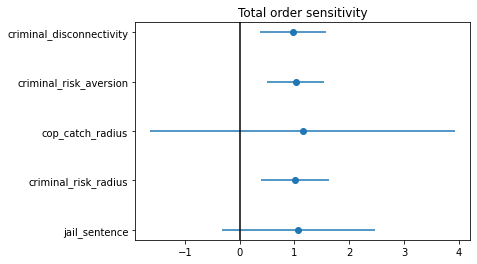

In [15]:
for Si in (Si_crimes, Si_jail, Si_centrum, Si_noord, Si_west, Si_zuid, Si_zuidoost, Si_oost, Si_nieuw_west):
    print(Si)

    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # # Second order
    # plot_index(Si, problem['names'], '2', 'Second order sensitivity')
    # plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()

# Run model

In [16]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 20})

In [17]:
num_runs = 2
outputs = []

for run in range(num_runs):
    m = SugarscapeCg(criminal_risk_radius=5, cop_catch_radius=1)
    print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
    output = run_model(m)
    outputs.append(output)

Search radius for criminal is :5 
 Catch radius is :1
     Criminal Wealth  Criminal Count  Criminal in Jail Count  Crimes commited  \
0              665.0              45                       0                0   
1              279.0              45                       0               14   
2                4.0              45                       0               30   
3              -97.0              45                       0               49   
4             -345.0              45                       2               65   
..               ...             ...                     ...              ...   
196          -2443.0              45                      14             3864   
197          -2340.0              45                      13             3886   
198          -2180.0              45                      11             3909   
199          -2028.0              45                      11             3933   
200          -1719.0              45                   

In [18]:
print(np.mean(outputs[1]["Zuid"]), np.mean(outputs[1]["Centrum"]))

3.990049751243781 4.059701492537314


## Plots

### Criminal wealths

In [19]:
all_wealths = get_data(outputs, 'Criminal Wealth')

# print(all_wealths[0])
print(all_wealths.shape)

(201, 2)


In [20]:
mean_wealths, cis_wealths = get_means_cis(all_wealths)

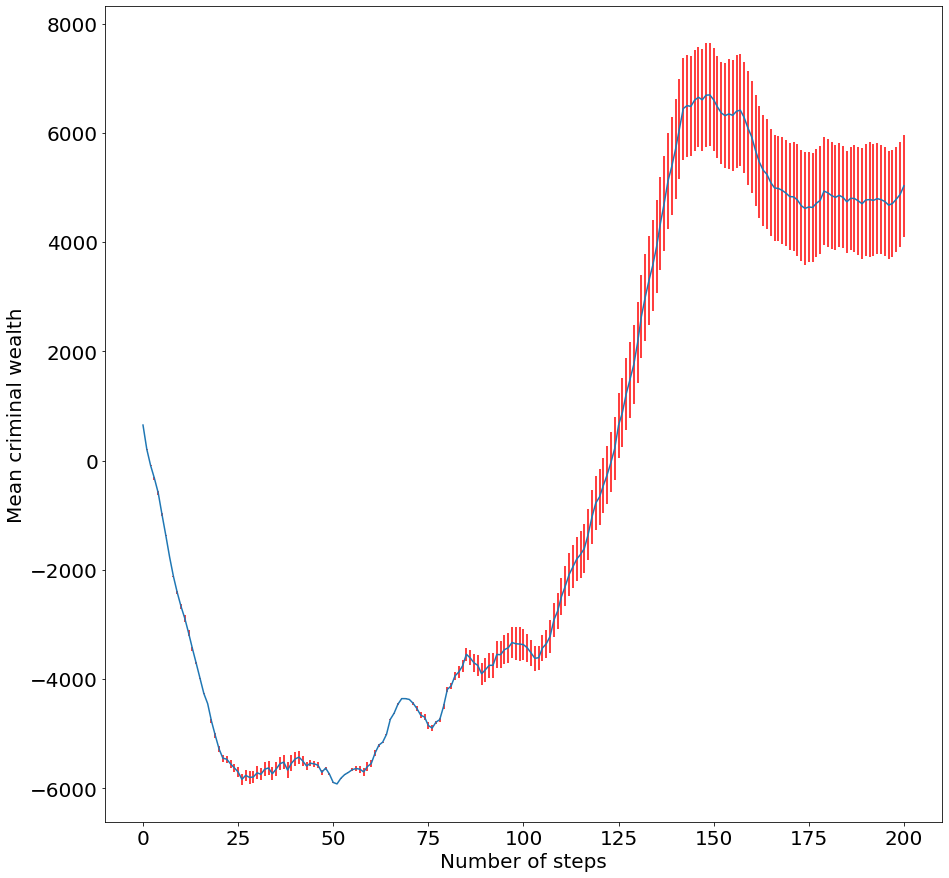

In [21]:
plot_errorbars(mean_wealths, cis_wealths, "Mean criminal wealth")

### Criminals in jail

In [22]:
jail_count = get_data(outputs, 'Criminal in Jail Count')

print(jail_count.shape)

(201, 2)


In [23]:
mean_jail_count, cis_jail_count = get_means_cis(jail_count)

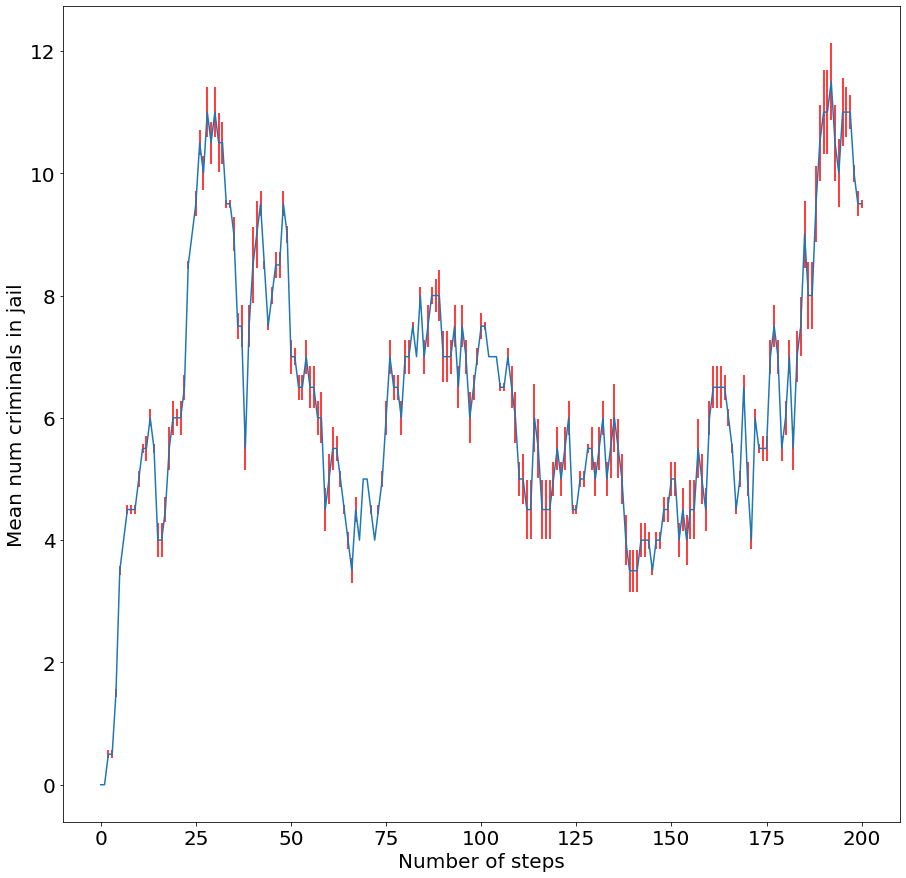

In [24]:
plot_errorbars(mean_jail_count, cis_jail_count, "Mean num criminals in jail")

### Crimes committed

In [25]:
crimes_count = get_data(outputs, 'Crimes commited')

print(crimes_count.shape)

(201, 2)


In [26]:
mean_crimes_count, cis_crimes_count = get_means_cis(crimes_count)

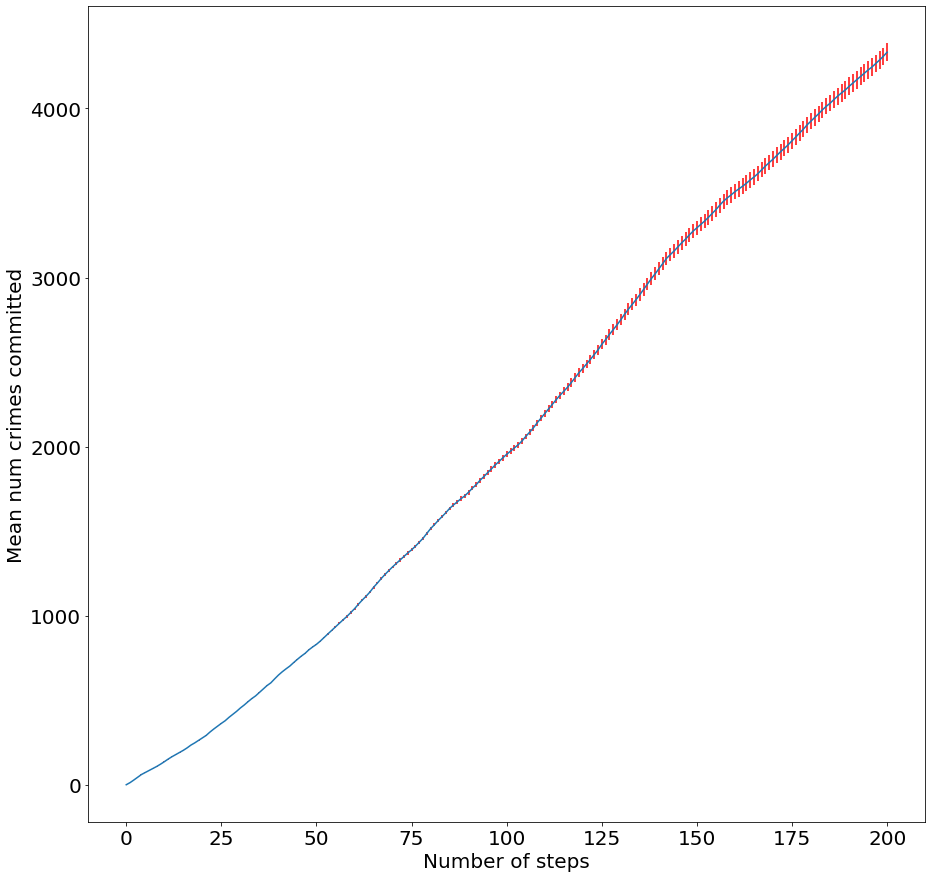

In [27]:
plot_errorbars(mean_crimes_count, cis_crimes_count, "Mean num crimes committed")

### District crimes

No handles with labels found to put in legend.


Zuidoost
West
Zuid
Oost
Centrum
Noord
Nieuw-West


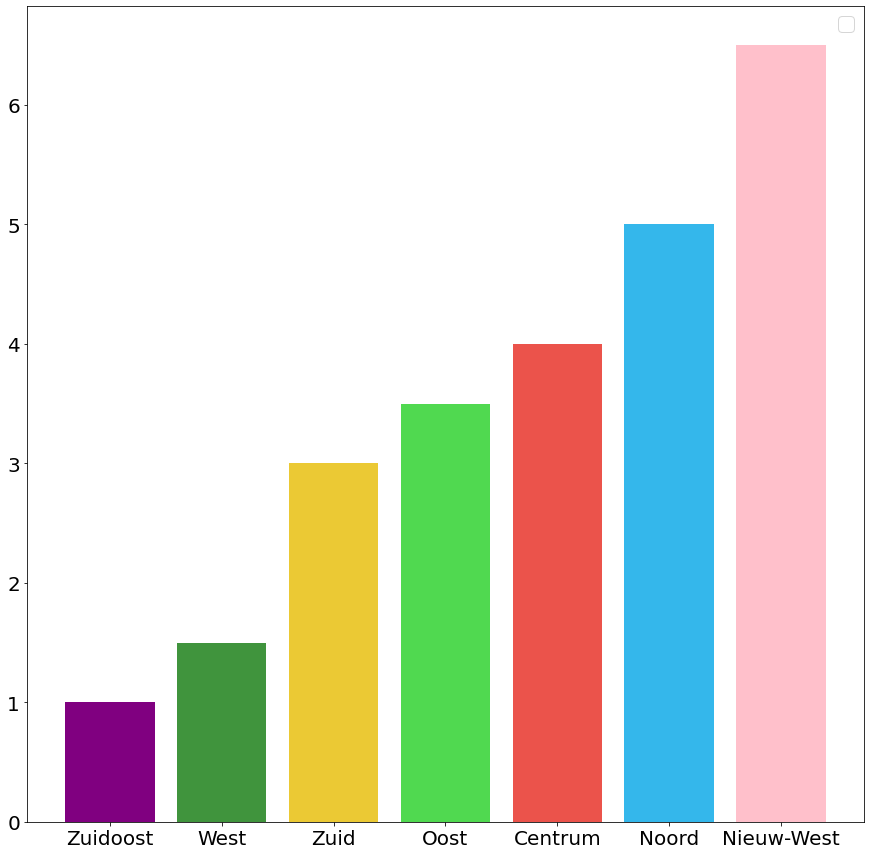

In [28]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

avg_crimes_per_distr_dict = get_average_crime_per_distr(outputs, district_names, 200)

# Sort colors
district_colors = []
for district in avg_crimes_per_distr_dict.keys():
    print(district)
    for dictionary in districts_dict:
        if dictionary['Label'] == district:
            district_colors.append(dictionary['Color'])

plot_district_means_bar(avg_crimes_per_distr_dict, district_colors)

In [29]:
all_district_means = []
all_district_cis = []

for district in district_names:
    crimes_count = get_data(outputs, district)
    mean_crimes_count, cis_crimes_count = get_means_cis(crimes_count)
    all_district_means.append(mean_crimes_count)
    all_district_cis.append(cis_crimes_count)

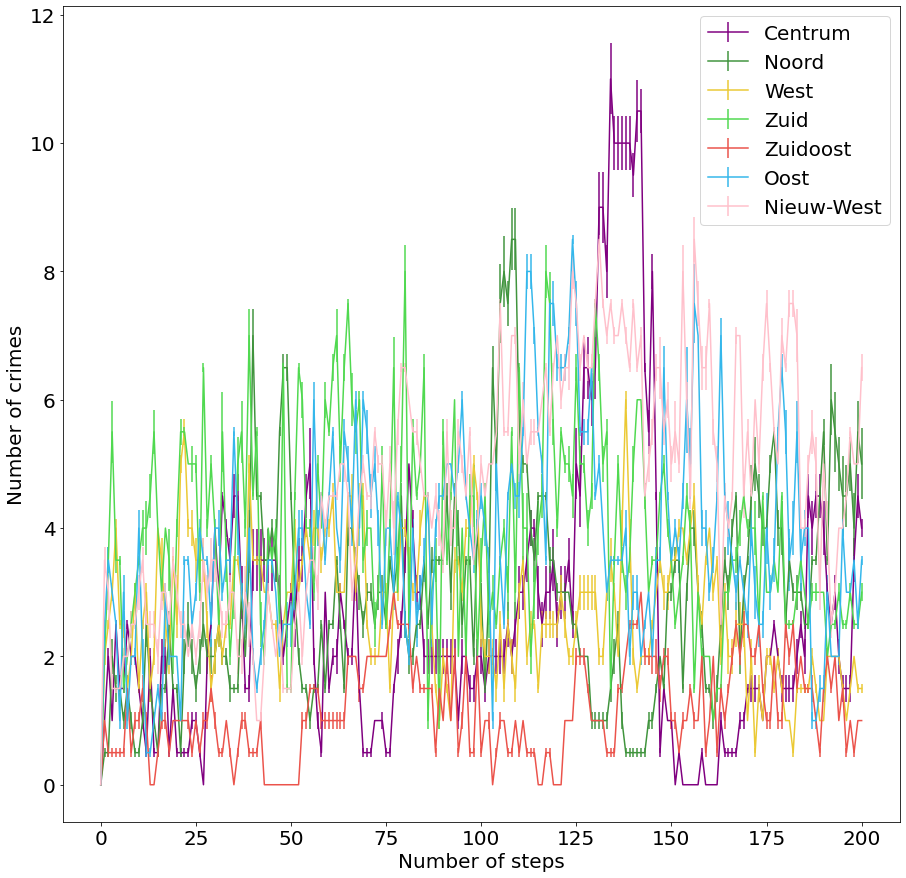

In [30]:
plot_district_crimes(all_district_means, all_district_cis, district_names, district_colors)

In [31]:
# print(len(all_district_means))
# print(len(all_district_means[0]))

# final_district_means = []
# for district in all_district_means:
#     final_district_means.append(district[-1])

# print(final_district_means)

# final_district_cis = []
# for district in all_district_cis:
#     final_district_cis.append(district[-1])

# print(final_district_cis)

In [32]:
# # Sort by size
# sorting = zip(final_district_means, district_names, district_colors)
# final_district_means, district_names, district_colors = zip(*sorted(sorting, key=lambda x : x[0]))

In [33]:
# plot_district_crimes_bar(final_district_means, final_district_cis, district_names, district_colors)